## 1. Import Dependancies

In [129]:
import pandas as pd # pandas==1.4.1
import numpy as np
from matplotlib import pyplot as plt # matplotlib==3.5.1
import seaborn as sns # seaborn==0.11.2

## 2. Import Data

In [65]:
# Import data and assign column names
data_fpath = '../data/GSOC_Data_DataCube.txt'
colnames_observable = ['od','od_uncertainty','max_ev','max_ev_uncertainty','flux300']
colnames_physical = ['mass_total','mass_Ni','energy','mass_distribution','radial_distribution']
df = pd.read_csv(data_fpath, sep=' ', names=colnames_observable+colnames_physical)
df.head()

,od,od_uncertainty,max_ev,max_ev_uncertainty,flux300,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,1.940628,0.179354,0.013531,0.000670,0.000003,0.75,0.15,0.75,hed8,hed8
1,2.071999,0.210287,0.012423,0.000615,0.000003,0.75,0.15,0.75,hed8,mwd
2,2.007982,0.198804,0.012744,0.000685,0.000003,0.75,0.15,0.75,hed8,N100
3,1.661535,0.189436,0.009935,0.000349,0.000003,0.75,0.15,0.75,hed8,w7dt
4,1.907672,0.178607,0.013343,0.000745,0.000003,0.75,0.15,2.00,hed8,hed8


In [68]:
# Creating a mapped dictionary of units
units = dict(zip(colnames_observable,['','','s⁻¹','s⁻¹','cm⁻²s⁻¹']))
units.update(dict(zip(colnames_physical,['M☉','M☉','10⁵¹ ergs','',''])))
units

{'od': '',
 'od_uncertainty': '',
 'max_ev': 's⁻¹',
 'max_ev_uncertainty': 's⁻¹',
 'flux300': 'cm⁻²s⁻¹',
 'mass_total': 'M☉',
 'mass_Ni': 'M☉',
 'energy': '10⁵¹ ergs',
 'mass_distribution': '',
 'radial_distribution': ''}

In [85]:
# Check columns for missing values and data-type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   od                   512 non-null    float64
 1   od_uncertainty       512 non-null    float64
 2   max_ev               512 non-null    float64
 3   max_ev_uncertainty   512 non-null    float64
 4   flux300              512 non-null    float64
 5   mass_total           512 non-null    float64
 6   mass_Ni              512 non-null    float64
 7   energy               512 non-null    float64
 8   mass_distribution    512 non-null    object 
 9   radial_distribution  512 non-null    object 
dtypes: float64(8), object(2)
memory usage: 40.1+ KB


- No missing data present.
- Columns 1 through 8 are numerical; 9 and 10 are strings.

## 3. Exploratory Data Analysis

### 3.1. Step 1 - Observable Parameters
#### Tasks:
- a
- b

In [87]:
# Show column statistics since all observable parameters are numerical data
df_obs = df.loc[:,colnames_observable]
df_obs.describe().iloc[1:]

,od,od_uncertainty,max_ev,max_ev_uncertainty,flux300
mean,2.576275,0.198927,0.012814,0.000512,0.000007
std,0.391005,0.021055,0.000849,0.000074,0.000004
min,1.661535,0.133992,0.009842,0.000313,0.000003
25%,2.321794,0.183659,0.012372,0.000458,0.000003
50%,2.559251,0.198672,0.012891,0.000501,0.000006
75%,2.812090,0.215768,0.013388,0.000556,0.000011
max,3.621963,0.239162,0.014723,0.000817,0.000015


In [134]:
# Obtain the relative uncertainties of optical depth
od_uncertainty_pct = df_obs.od_uncertainty / df_obs.od
od_uncertainty_pct.describe().iloc[1:]

mean    0.078545
std     0.011796
min     0.047808
25%     0.069775
50%     0.078088
75%     0.086126
max     0.114326
dtype: float64

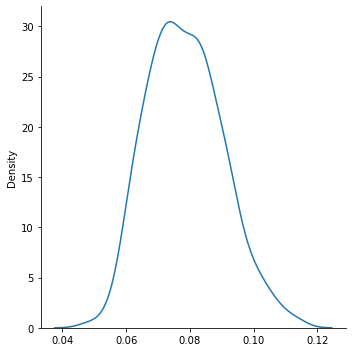

In [162]:
# Distribution of relative uncertainties of optical depth
sns.displot(od_uncertainty_pct, kind='kde')
plt.show()

In [135]:
# Obtain the relative uncertainties of maximum expansion velocity
max_ev_uncertainty_pct = df_obs.max_ev_uncertainty / df_obs.max_ev
max_ev_uncertainty_pct.describe().iloc[1:]

mean    0.039927
std     0.005138
min     0.026519
25%     0.036309
50%     0.039165
75%     0.042926
max     0.063529
dtype: float64

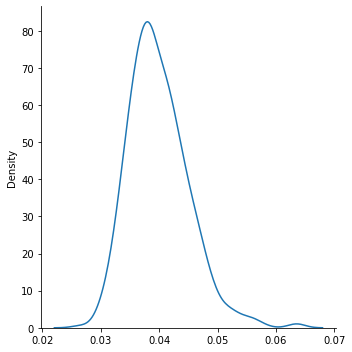

In [161]:
# Distribution of relative uncertainties of maximum expansion velocity
sns.displot(max_ev_uncertainty_pct, kind='kde')
plt.show()

- The maximum uncertainty for optical depth is 11.4% and is normally distributed.
    - mean=0.078545, std=0.011796
- The maximum uncertainty for the maximum expansion velocity is 6.4% and is normally distributed.
    - mean=0.039927, std=0.005138
- We can use the mean and standard deviation to bootstrap the existing dataset to create new features for training to obtain a more robust classification model.

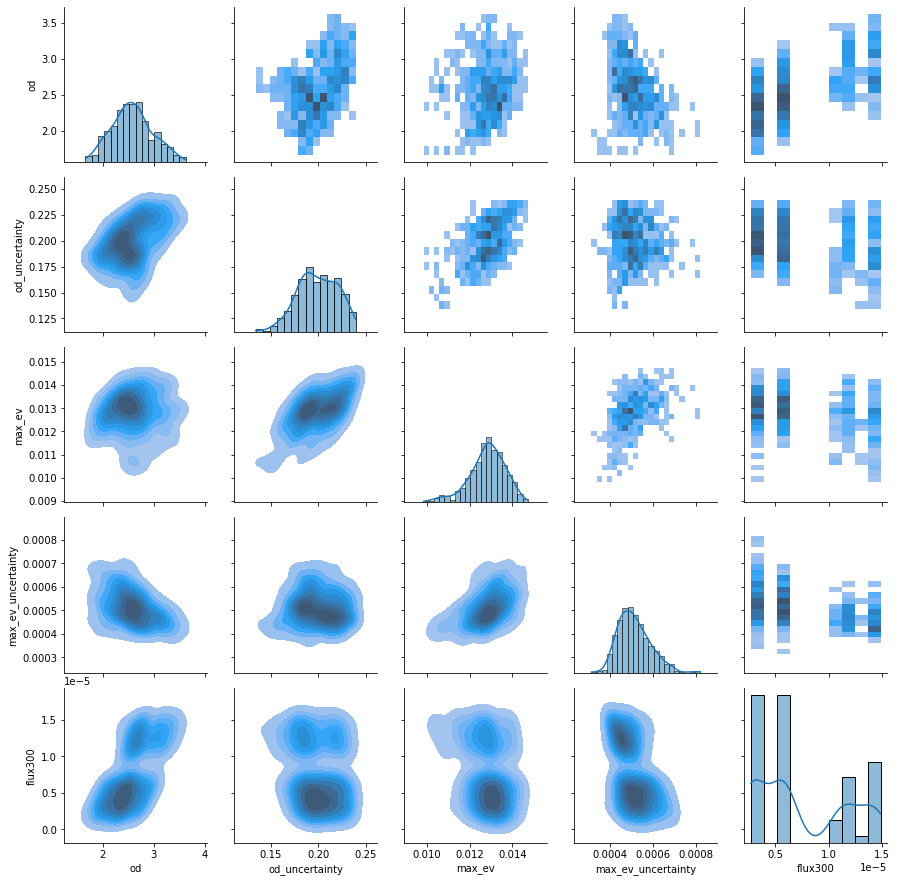

In [121]:
# Pairplot
g = sns.PairGrid(df_obs)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

- Data for optical depth and maximum expansion velocity seems to be normally distributed. 
- The histogram for emergent flux seems to be missing alot of bins. 
- Uncertainties of optical depth and maximum expansion velocity seems to be positively correlated. Which suggests that a percent-wise bootstrapping is feasible.
- Optical depth and flux seems to be positively correlated.
- Maximum expansion velocity and flux seems to have little relation. 
- Maximum expansion velocity and optical depth seems to have little relation. 

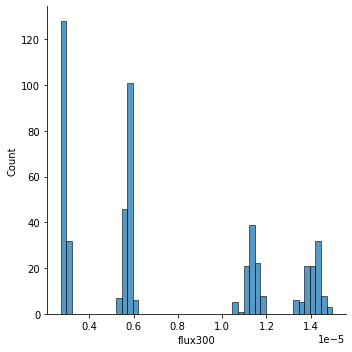

In [155]:
# Examine flux data
sns.displot(df_obs.flux300, binwidth=2.5e-7)
plt.show()

- Flux values seem to have 4 distinct bins:
    - 0.1e-5 to 0.3e-5
    - 0.5e-5 to 0.65e-5
    - 1.0e-5 to 1.2e-5
    - 1.3e-5 to 1.6e-5
- We can consider splitting these into 4 categories between the following values: [0, 0.4e-5, 0.85e-5, 1.25e-5, 1.6e-5]

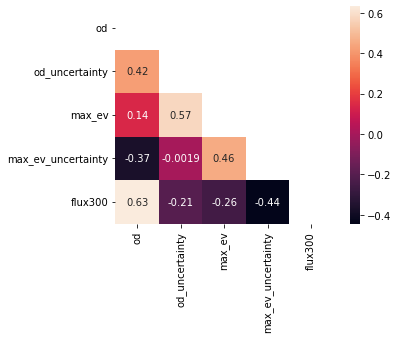

In [156]:
# Pearsons correlation heatmap
corr = df_obs.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_obs.corr(), mask=mask, square=True, annot=True)
plt.show()

In [ ]:
- 